In [46]:
import nevis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

nevis.download_os_terrain_50()
f = nevis.linear_interpolant()
x_max, y_max = nevis.dimensions()

def run_opt(xatol, fatol, seed, boundaries, library):
    def wrapper(x, grad=None):
        points_visited.append(x)
        return -f(*x)
    points_visited = []

    x1, x2, y1, y2 = boundaries
    np.random.seed(seed * 1099)
    a = np.random.rand() * (x2 - x1) + x1
    b = np.random.rand() * (y2 - y1) + y1

    if library == 'scipy':
        from scipy.optimize import minimize

        result = minimize(
            wrapper,
            x0=(a, b),
            bounds=[(x1, x2), (y1, y2)],
            method='Nelder-Mead',
            options={'xatol': xatol, 'fatol': fatol}
        )
        z = -result.fun
    
    elif library == 'nlopt':
        import nlopt

        opt = nlopt.opt(nlopt.LN_NELDERMEAD, 2)
        opt.set_lower_bounds([x1, y1])
        opt.set_upper_bounds([x2, y2])
        opt.set_xtol_abs(xatol)
        opt.set_ftol_abs(fatol)
        opt.set_min_objective(wrapper)
        z = opt.optimize([a, b])
        z = -opt.last_optimum_value()
    
    return z, len(points_visited)

def run_exps(xatol, fatol, boundaries, run, library):
    zs = []
    evals = []
    for i in range(run):
        z, e = run_opt(xatol, fatol, i, boundaries, library)
        zs.append(z)
        evals.append(e)

    return np.mean(zs), np.std(zs), np.mean(evals), np.std(evals)


Downloaded, unpacked, and processed file already found: Skipping.


In [47]:
from tqdm import tqdm

xatol_values = [0.1, 1, 5, 10, 20]
fatol_values = [0.1, 0.2, 1]

res = []

for library in ['scipy', 'nlopt']:
    for xatol in tqdm(xatol_values):
        for fatol in fatol_values:
            for problem in ['schiehallion', 'macdui']:
                _, boundaries = eval(f'nevis.{problem}()')
                a, b, c, d = run_exps(xatol, fatol, boundaries, 5000, library)
                res.append({
                    'library': library,
                    'xatol': xatol,
                    'fatol': fatol,
                    'problem': problem,
                    'height_mean': a,
                    'height_std': b,
                    'eval_mean': c,
                    'eval_std': d
                })

100%|██████████| 5/5 [02:25<00:00, 29.18s/it]


In [48]:
df = pd.DataFrame(res)
df[df['problem'] == 'macdui'].sort_values(by=['xatol', 'fatol'])

,library,xatol,fatol,problem,height_mean,height_std,eval_mean,eval_std
1,scipy,0.1,0.1,macdui,1013.988776,235.461630,90.4034,33.611579
31,nlopt,0.1,0.1,macdui,1017.664103,224.074337,52.9492,16.275055
3,scipy,0.1,0.2,macdui,1013.988776,235.461630,90.4034,33.611579
33,nlopt,0.1,0.2,macdui,1017.450907,224.068422,48.2112,14.864730
5,scipy,0.1,1.0,macdui,1013.988776,235.461630,90.4034,33.611579
35,nlopt,0.1,1.0,macdui,1015.925019,224.170043,39.1346,11.960940
7,scipy,1.0,0.1,macdui,1013.955423,235.455821,72.0188,24.773277
37,nlopt,1.0,0.1,macdui,1017.662263,224.072926,52.7848,16.070833
9,scipy,1.0,0.2,macdui,1013.954514,235.454966,71.9210,24.749924
39,nlopt,1.0,0.2,macdui,1017.450588,224.068054,48.1974,14.843047


In [49]:
df[df['problem'] != 'macdui'].sort_values(by=['xatol', 'fatol'])

,library,xatol,fatol,problem,height_mean,height_std,eval_mean,eval_std
0,scipy,0.1,0.1,schiehallion,999.267504,185.126907,79.0566,17.034899
30,nlopt,0.1,0.1,schiehallion,990.623632,180.918030,59.0170,16.204194
2,scipy,0.1,0.2,schiehallion,999.267504,185.126907,79.0566,17.034899
32,nlopt,0.1,0.2,schiehallion,990.130620,181.240327,54.1844,15.616850
4,scipy,0.1,1.0,schiehallion,999.267504,185.126907,79.0566,17.034899
34,nlopt,0.1,1.0,schiehallion,986.015833,183.687878,42.6134,13.715157
6,scipy,1.0,0.1,schiehallion,998.913947,185.453597,65.5552,14.405213
36,nlopt,1.0,0.1,schiehallion,990.456033,181.030175,55.8698,14.782532
8,scipy,1.0,0.2,schiehallion,998.889056,185.442724,63.6054,13.887580
38,nlopt,1.0,0.2,schiehallion,990.119494,181.235156,53.3984,15.188432


In [50]:
scipy_macdui_df = df[(df["problem"] == "macdui") & (df["library"] == "scipy")]
scipy_macdui_df

,library,xatol,fatol,problem,height_mean,height_std,eval_mean,eval_std
1,scipy,0.1,0.1,macdui,1013.988776,235.461630,90.4034,33.611579
3,scipy,0.1,0.2,macdui,1013.988776,235.461630,90.4034,33.611579
5,scipy,0.1,1.0,macdui,1013.988776,235.461630,90.4034,33.611579
7,scipy,1.0,0.1,macdui,1013.955423,235.455821,72.0188,24.773277
9,scipy,1.0,0.2,macdui,1013.954514,235.454966,71.9210,24.749924
11,scipy,1.0,1.0,macdui,1013.954436,235.454919,71.9022,24.744063
13,scipy,5.0,0.1,macdui,1013.813222,235.505321,60.4682,19.902527
15,scipy,5.0,0.2,macdui,1013.796799,235.497650,59.5934,19.549478
17,scipy,5.0,1.0,macdui,1013.771029,235.480609,58.9796,19.279740
19,scipy,10.0,0.1,macdui,1013.757753,235.499864,56.6074,18.553384


In [51]:
nlopt_macdui_df = df[(df["problem"] == "macdui") & (df["library"] == "nlopt")]
nlopt_macdui_df

,library,xatol,fatol,problem,height_mean,height_std,eval_mean,eval_std
31,nlopt,0.1,0.1,macdui,1017.664103,224.074337,52.9492,16.275055
33,nlopt,0.1,0.2,macdui,1017.450907,224.068422,48.2112,14.864730
35,nlopt,0.1,1.0,macdui,1015.925019,224.170043,39.1346,11.960940
37,nlopt,1.0,0.1,macdui,1017.662263,224.072926,52.7848,16.070833
39,nlopt,1.0,0.2,macdui,1017.450588,224.068054,48.1974,14.843047
41,nlopt,1.0,1.0,macdui,1015.925019,224.170043,39.1346,11.960940
43,nlopt,5.0,0.1,macdui,1017.560226,224.025480,50.5972,14.461056
45,nlopt,5.0,0.2,macdui,1017.392055,224.028922,47.2888,13.915294
47,nlopt,5.0,1.0,macdui,1015.924482,224.169532,39.1234,11.942955
49,nlopt,10.0,0.1,macdui,1017.263282,224.168117,47.9510,13.375507


Text(0.5, 1.0, 'Nelder-Mead on Macdui problem with different xatol and fatol')

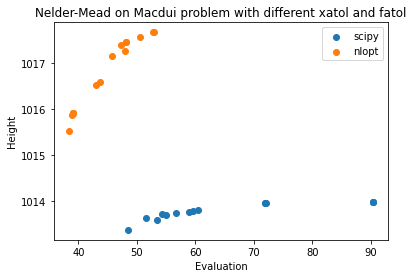

In [52]:
plt.scatter(scipy_macdui_df['eval_mean'], scipy_macdui_df['height_mean'], label='scipy')
plt.scatter(nlopt_macdui_df['eval_mean'], nlopt_macdui_df['height_mean'], label='nlopt')
plt.ylabel('Height')
plt.xlabel('Evaluation')
plt.legend()
plt.title('Nelder-Mead on Macdui problem with different xatol and fatol')

In [53]:
scipy_schiehallion_df = df[(df["problem"] != "macdui") & (df["library"] == "scipy")]
scipy_schiehallion_df

,library,xatol,fatol,problem,height_mean,height_std,eval_mean,eval_std
0,scipy,0.1,0.1,schiehallion,999.267504,185.126907,79.0566,17.034899
2,scipy,0.1,0.2,schiehallion,999.267504,185.126907,79.0566,17.034899
4,scipy,0.1,1.0,schiehallion,999.267504,185.126907,79.0566,17.034899
6,scipy,1.0,0.1,schiehallion,998.913947,185.453597,65.5552,14.405213
8,scipy,1.0,0.2,schiehallion,998.889056,185.442724,63.6054,13.887580
10,scipy,1.0,1.0,schiehallion,998.880645,185.439005,62.8356,13.711272
12,scipy,5.0,0.1,schiehallion,998.830606,185.476422,62.2462,14.732834
14,scipy,5.0,0.2,schiehallion,998.580184,185.579249,58.2520,13.737310
16,scipy,5.0,1.0,schiehallion,998.189439,185.455044,51.9492,11.835718
18,scipy,10.0,0.1,schiehallion,998.815306,185.479664,61.8352,15.078967


In [54]:
nlopt_schiehallion_df = df[(df["problem"] != "macdui") & (df["library"] != "scipy")]
nlopt_schiehallion_df

,library,xatol,fatol,problem,height_mean,height_std,eval_mean,eval_std
30,nlopt,0.1,0.1,schiehallion,990.623632,180.918030,59.0170,16.204194
32,nlopt,0.1,0.2,schiehallion,990.130620,181.240327,54.1844,15.616850
34,nlopt,0.1,1.0,schiehallion,986.015833,183.687878,42.6134,13.715157
36,nlopt,1.0,0.1,schiehallion,990.456033,181.030175,55.8698,14.782532
38,nlopt,1.0,0.2,schiehallion,990.119494,181.235156,53.3984,15.188432
40,nlopt,1.0,1.0,schiehallion,986.015833,183.687878,42.6134,13.715157
42,nlopt,5.0,0.1,schiehallion,989.394056,181.291589,46.3754,12.338107
44,nlopt,5.0,0.2,schiehallion,989.174408,181.529600,45.9324,12.564594
46,nlopt,5.0,1.0,schiehallion,985.919473,183.691053,41.7696,13.166188
48,nlopt,10.0,0.1,schiehallion,987.944950,181.810883,41.6164,11.468864


Text(0.5, 1.0, 'Nelder-Mead on Schiehallion problem with different xatol and fatol')

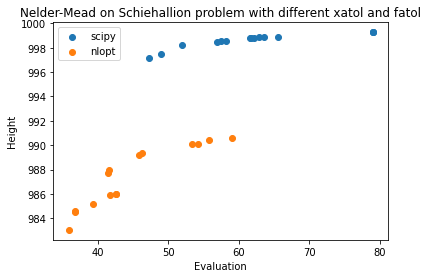

In [55]:
plt.scatter(scipy_schiehallion_df['eval_mean'], scipy_schiehallion_df['height_mean'], label='scipy')
plt.scatter(nlopt_schiehallion_df['eval_mean'], nlopt_schiehallion_df['height_mean'], label='nlopt')
plt.ylabel('Height')
plt.xlabel('Evaluation')
plt.legend()
plt.title('Nelder-Mead on Schiehallion problem with different xatol and fatol')

`xtol` and `ftol` are set to have a `OR` relationship in `nlopt` while `AND` in `scipy`

In [67]:
print(run_opt(1e-4, 1000, 1, nevis.macdui()[1], 'nlopt'))
print(run_opt(1000, 1e-4, 1, nevis.macdui()[1], 'nlopt'))
print(run_opt(1e-4, 1e-4, 1, nevis.macdui()[1], 'nlopt'))
print(run_opt(1000, 1000, 1, nevis.macdui()[1], 'nlopt'))

(1016.8749558999883, 3)
(1111.8166443683963, 20)
(1125.9000146223234, 127)
(1016.8749558999883, 3)


In [68]:
print(run_opt(1e-4, 1000, 1, nevis.macdui()[1], 'scipy'))
print(run_opt(1000, 1e-4, 1, nevis.macdui()[1], 'scipy'))
print(run_opt(1e-4, 1e-4, 1, nevis.macdui()[1], 'scipy'))
print(run_opt(1000, 1000, 1, nevis.macdui()[1], 'scipy'))

(1195.699950079833, 137)
(1195.6998535881046, 100)
(1195.699950079833, 137)
(1194.1811651275607, 27)
